# Verify

In [1]:
print("Hello Krub")

Hello Krub


# Setup

In [4]:
import numpy as np
import JupyterNotebooksLib as slicernb

In [5]:
loadScene("data/slicer_gs_clean/2023-10-26-Scene.mrml")

RuntimeError: Failed to load node from file: data/slicer_gs_clean/2023-10-26-Scene.mrml

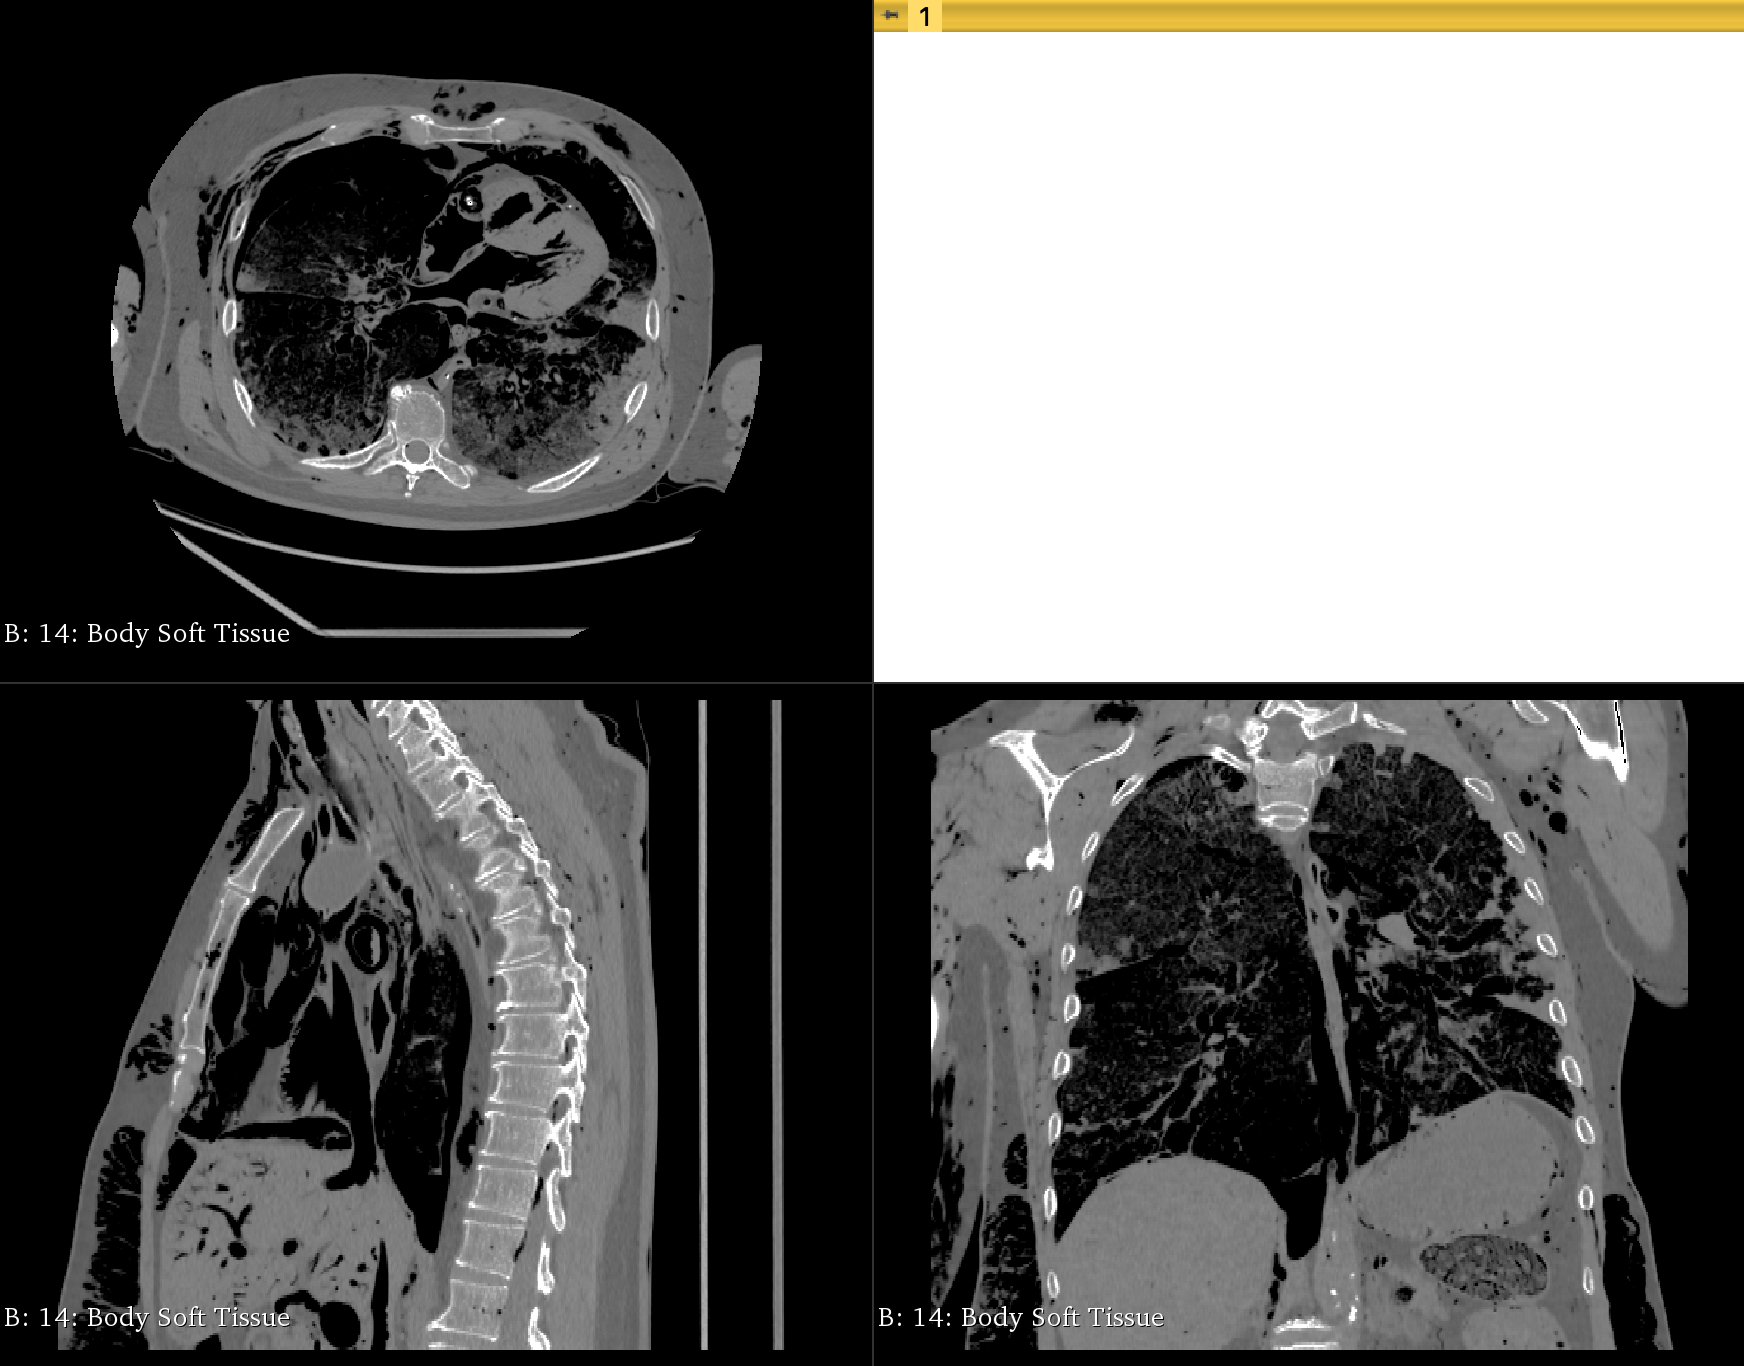

In [6]:
slicernb.ViewDisplay()

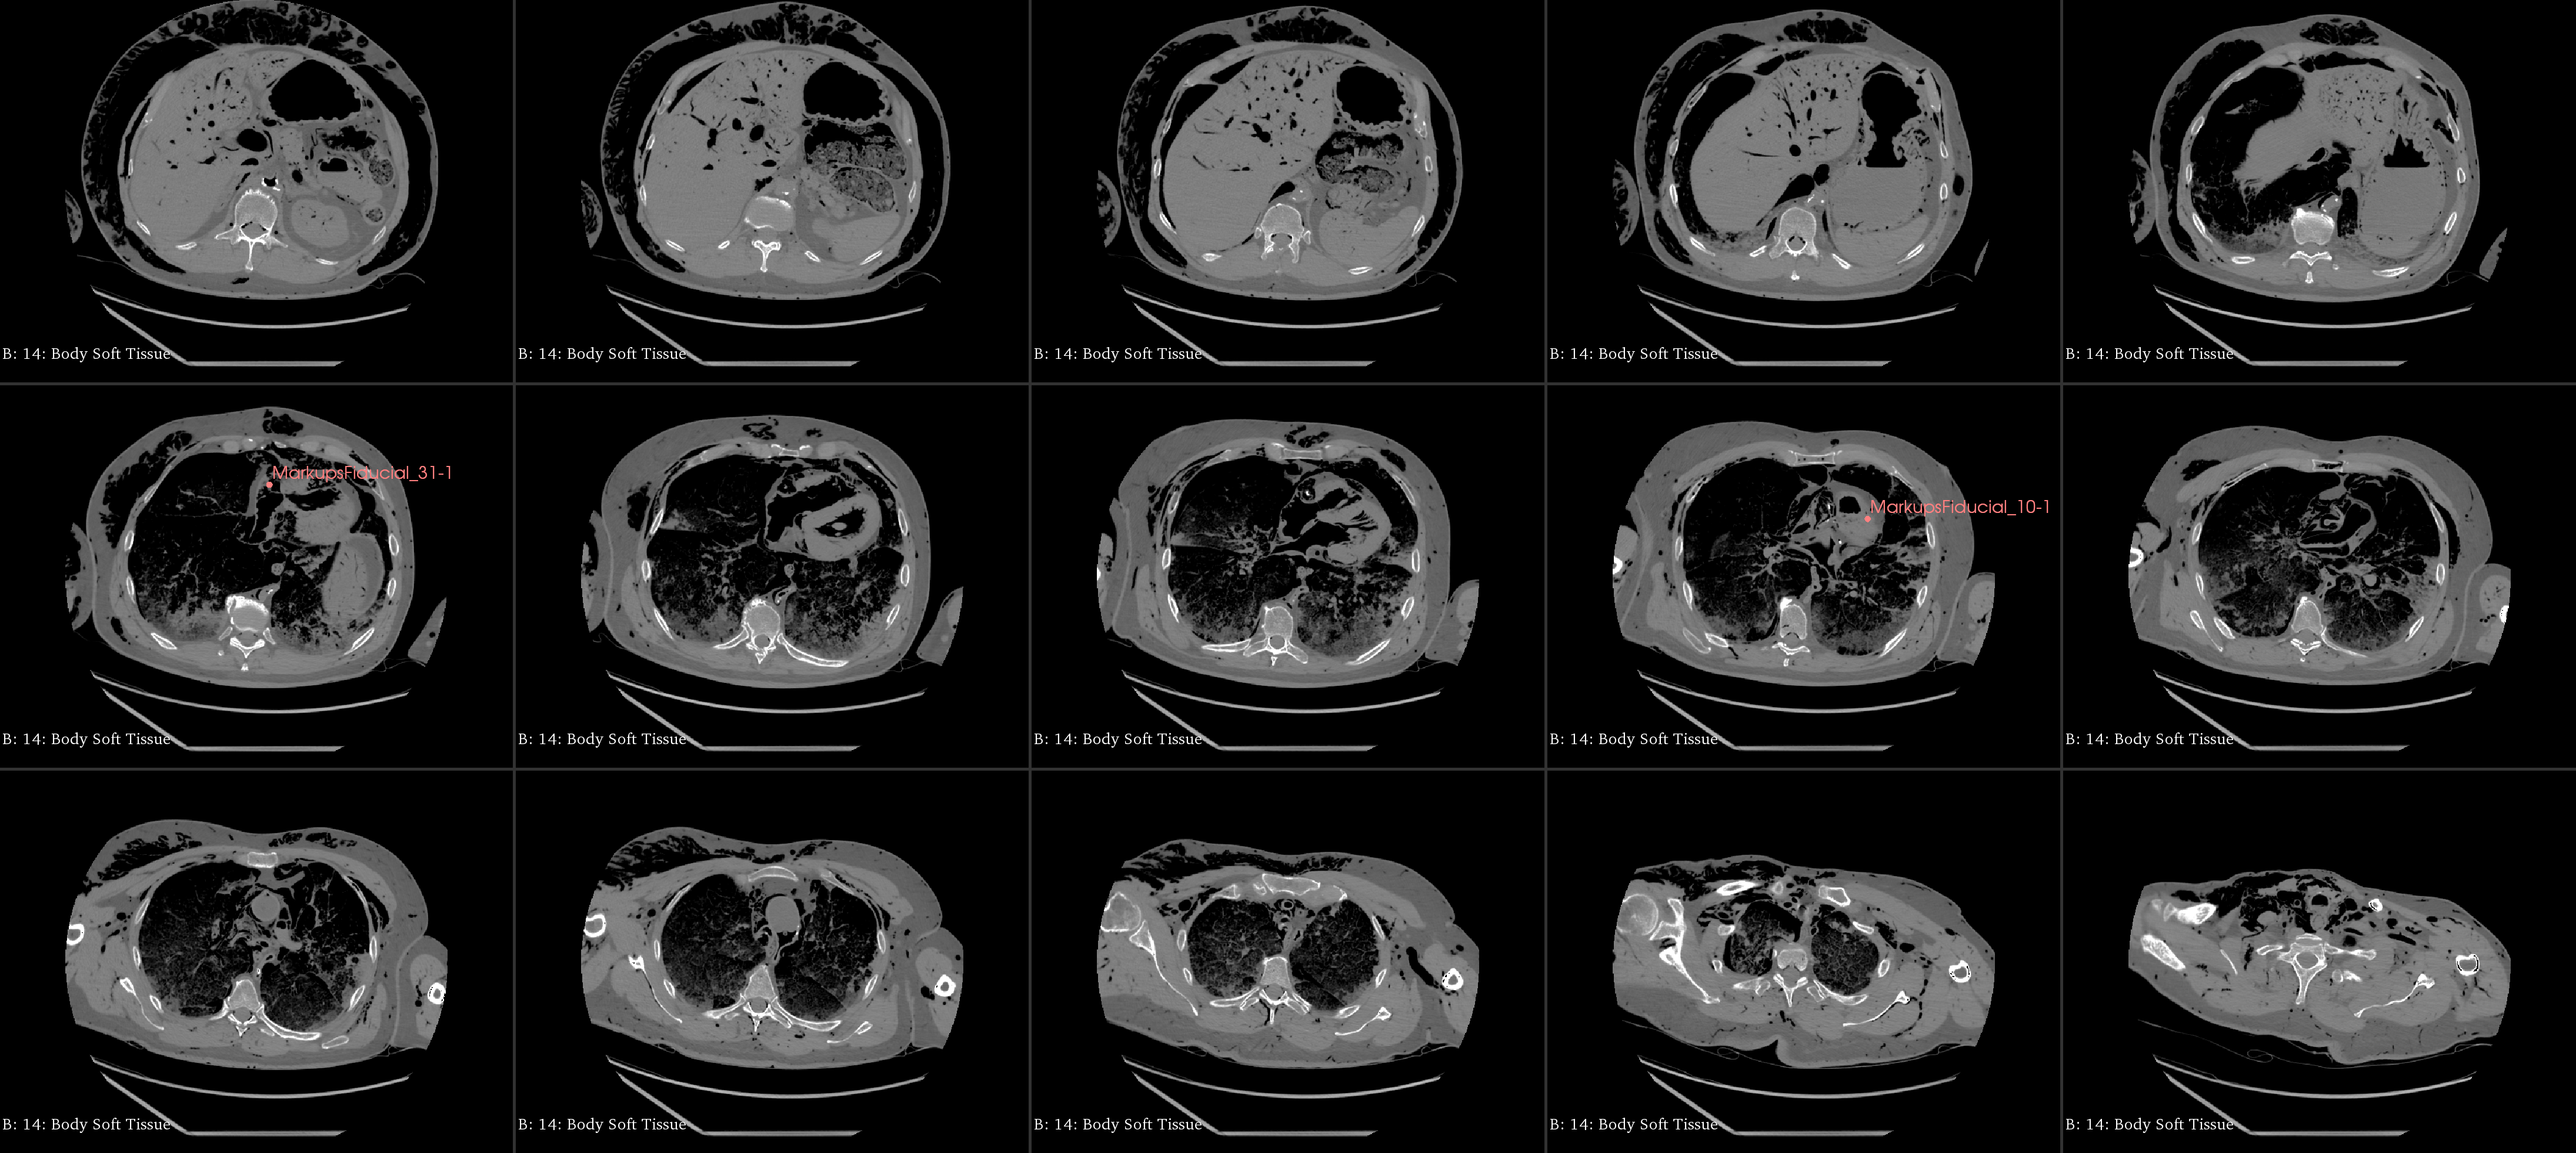

In [7]:
slicernb.ViewLightboxDisplay(columns=5, rows=3, rangeShrink=[15,20])

In [8]:
# # Clear scene
# slicer.mrmlScene.Clear(False)

# Load from local file
# volume = slicer.util.loadVolume('data/MRBrainTumor1.nrrd')


# # Lightbox view
# slicernb.ViewLightboxDisplay("Red", rangeShrink=[45,50])
pass

In [9]:
VOLUME_NODE_NAME = "14: Body Soft Tissue"
CANVAS_NODE_NAME = "output_canvas"
MYNULL = -2_147_483_648

In [10]:
volume_node = getNode(VOLUME_NODE_NAME)
volume_display = volume_node.GetDisplayNode()
volume_display.InterpolateOff()

canvas_node = getNode(CANVAS_NODE_NAME)
canvas_display = canvas_node.GetDisplayNode()
canvas_display.InterpolateOff()

In [11]:
# create segmentation node to store result
seg_node = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLSegmentationNode")

seg_node.SetName("segmentation_result")
labelmap_node = getNode('labelmap_template')


In [13]:
# import MRMLCorePython
# labelmap_node = MRMLCorePython.vtkMRMLLabelMapVolumeNode()
pass

In [14]:
v_arr = slicer.util.array(VOLUME_NODE_NAME)
c_arr = slicer.util.array(CANVAS_NODE_NAME)
print(v_arr.shape)
print(v_arr.min())
print(v_arr.max())
print(v_arr.dtype)

(275, 512, 512)
-3024
1960
int32


In [11]:
# blank canvas
c_tmp = c_arr.copy()
c_tmp[:] = MYNULL
updateVolumeFromArray(canvas_node, c_tmp)
del c_tmp

# Util

In [12]:
def create_result_seg(in_arr):
    # seg_arr = np.zeros(v_arr.shape)
    # seg_arr[100:,:,:] = 1
    seg_arr = in_arr.copy().astype('int16')
    updateVolumeFromArray(labelmap_node, seg_arr)
    slicer.modules.segmentations.logic().ImportLabelmapToSegmentationNode(labelmap_node, seg_node)


In [13]:
# d_arr = v_arr.copy()
# r_arr = v_arr.copy()

In [14]:
LAD_nodes = getNodes("LAD_*")
LCX_nodes = getNodes("LCX_*")
RCA_nodes = getNodes("RCA_*")
x = LAD_nodes[list(LAD_nodes.keys())[0]]

In [15]:
# LCX, LAD, RCA
nodes_pos = [None, None, None]

for i,node_group in enumerate([list(LAD_nodes.values()), 
                             list(LCX_nodes.values()), 
                             list(RCA_nodes.values())]):
    nodes_pos[i] = []
    
    for node in node_group:
        position = [0,0,0]
        node.GetNthFiducialPosition(0, position)
        if position != [0, 0, 0]:
            nodes_pos[i].append(position) 
    
    nodes_pos[i] = np.array(nodes_pos[i])
nodes_pos

nodes_pos_norm = [np.round(nodes_pos[i]).astype("int32") + np.array([275//2, 512//2, 0]) for i in range(3)]
print(nodes_pos)
print(nodes_pos_norm)

np.array([275//2, 512//2, 512//2])
# print(x.__dir__())

[array([[ -21.5655673 ,   45.4757882 , -386.5       ],
       [ -25.11234184,   46.630552  , -386.5       ],
       [ -31.71099214,   50.13608498, -389.        ],
       [ -34.31844552,   51.38546313, -390.25      ],
       [ -36.26009046,   53.11854243, -391.5       ],
       [ -37.69393932,   54.9108535 , -392.75      ],
       [ -40.44214962,   57.77855121, -395.25      ],
       [ -43.54882214,   60.52676152, -397.75      ],
       [ -46.47626356,   63.21522812, -399.        ]]), array([[ -16.61776477,   40.89474248, -389.        ],
       [ -15.94718328,   40.26251835, -391.5       ],
       [ -14.97580568,   39.73946888, -394.        ],
       [ -13.85498537,   38.99225534, -396.5       ],
       [ -13.63082131,   37.79671368, -399.        ],
       [ -14.00442808,   36.45172931, -400.25      ],
       [ -13.22317808,   35.30209255, -400.73523933],
       [ -13.9287411 ,   34.88922931, -400.72291994]]), array([[   8.7076287 ,   97.40301089, -460.25      ],
       [   9.78533142, 

array([137, 256, 256])

In [30]:
intensity = []
for i in range(3):
    for j in range(len(nodes_pos_norm[i])):
        x,y,z = nodes_pos_norm[i][j,:]
        intensity.append(d_arr[x,y,z])


In [12]:
d_arr = v_arr.copy()
d_arr[d_arr > -200] = MYNULL
d_arr[d_arr < -1050] = MYNULL
d_arr[d_arr != MYNULL] = 500

updateVolumeFromArray(canvas_node, d_arr)

del d_arr

In [25]:
# start_point = [0,0,0] 
# getNode("LAD_2").GetNthFiducialPosition(0, start_point)
# # start_point = (start_point * np.array([-1, 1, -1])).astype("int32")
# start_point = (start_point * np.array([1, 1, 1])).astype("int32")
# i,j,k = start_point

i,j,k = [162, 198, 313]

d_arr = v_arr.copy()
d_arr[:] = MYNULL
d_arr[i-50:i+50,j-50:j+50,k-50:k+50] = 500
updateVolumeFromArray(canvas_node, d_arr)


In [31]:
# numpy data format
# i - z 0 is downmost
# j - y 0 is topmost
# k - x 0 is leftmost
pass

In [16]:
# bfs
seed = (162, 198, 313)
queue = [seed]
visited = {seed}
mask_index = {(seed,0)}
# it_index = [0]

offsets = []
for i in [-1,0,1]:
    for j in [-1,0,1]:
        for k in [-1,0,1]:
            if i != 0 or j != 0 or k != 0:
                offsets.append(np.array([i,j,k]))

r_arr = v_arr.copy()
it = 0

while len(queue) and it < 10000:
    it += 1
    v = queue.pop(0)
    
    vi, vj, vk = v
    vb = r_arr[vi, vj, vk]
    
    pos = np.array(v)
    candidates = [tuple(pos + offset) for offset in offsets]
    
    for w in candidates:
        wi, wj, wk = w
        
        
        if w in visited:
            continue
        visited.add(w)    
        
        wb = r_arr[wi, wj, wk]
        diff = abs(vb - wb)
        if diff < 250 and wb < -300 and wb > -1100:
            mask_index.add((w,it))
            queue.append(w)
            # it_index.append(it)
    # print(candidates)
    # break

c_arr = v_arr.copy()
c_arr[:] = MYNULL
for (i,j,k),it in mask_index:
    c_arr[i,j,k] = it
    
updateVolumeFromArray(canvas_node, c_arr)
print(it)



2606


In [18]:

create_result(c_arr)

In [69]:
seed = (162, 198, 313)
i,j,k = seed

c_arr = v_arr.copy()
c_arr[:] = MYNULL
c_arr[i,j,k] = 2000
updateVolumeFromArray(canvas_node, c_arr)


True